# AI Community @ Семинар № 9, весна 2018
## Autoencoders. Introduction.

Автоэнкодер - это нейронная сеть, которая тренируется с целью воспроизвести(копировать) свой вход. Можно представлять, что он состоит из двух частей: кодировщика(encoder) и декодировщика(decoder). Энкодер переводит входной вектор $x$ в некоторый вектор $h$. Декодер же переводит $h$ в вектор $\hat{x}$, который находится в пространстве той же размерности, что и $x$.

<img src='images/autoencoder-example.jpg'>

Вы могли подумать: "Что-то здесь не так. Зачем копировать то, что дают на вход? Какая из этого польза?"  
И вы правильно спросили. Такие автоэнкодеры абсолютно бесполезны, и поэтому обычно во время тренировки им мешают идеально копировать свой вход(регуляризуют). Напрмер, задают вектор $h$ в размерности меньшей, чем $x$, как это изображено ниже. Это приводит к тому, что энкодер учится выделять важные признаки. После тренировки такого автоэнкодера можно отбросить декодер, а энкодер использовать, например, в задачах классификации или регрессии.

<img src='images/autoencoder.png'>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

Проведем небольшой эксперимент. Накидаем точек на плоскость:

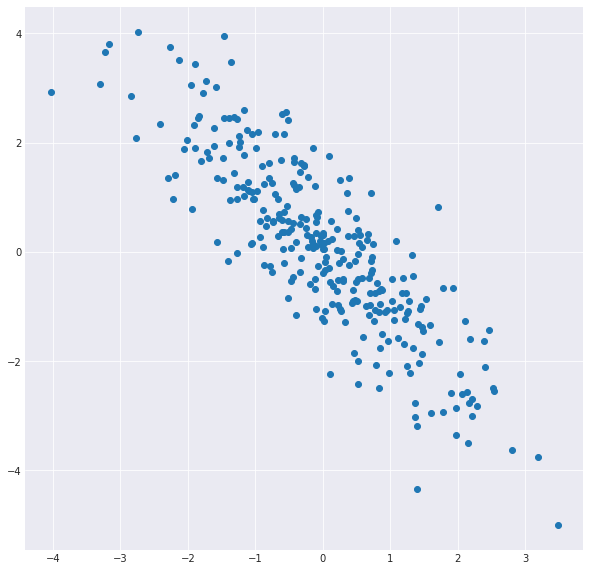

In [2]:
n_points = 100
mean = np.array([0.0, 0.0])
cov = np.array([[1.0, -1.0], 
                [-2.0, 3.0]])
X = np.random.multivariate_normal(mean, cov, 300)
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1]);

Вспомним алгоритм PCA, который уменьшал размерность вектора признаков. Посмотрим, как это будет выглядеть в случае, когда точки в двумерном пространстве проецируются на одномерное:

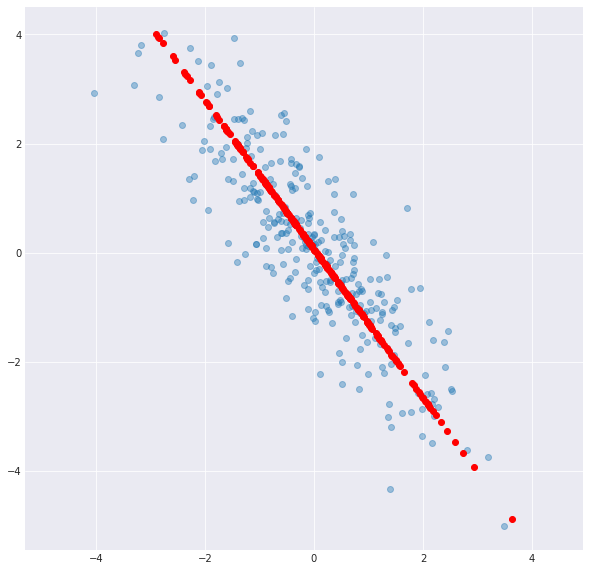

In [3]:
pca = PCA(n_components=1)
pca.fit(X)
X_transformed_pca = pca.inverse_transform(pca.transform(X))

plt.figure(figsize=(10, 10))
plt.axis('equal')
plt.scatter(X[:, 0], X[:, 1], alpha=0.4)
plt.scatter(X_transformed_pca[:, 0], X_transformed_pca[:, 1], color='r');

А теперь обучим автоэнкодер такой, что:
1. Энкодер будет состоять из одного линейного слоя и переводить вектор $x$ из ${\rm I\!R}^2$ в вектор $h$ из ${\rm I\!R}^1$
2. Декодер наоборот будет переводить скрытый вектор $h$ из ${\rm I\!R}^1$ в вектор $\hat{x}$ из ${\rm I\!R}^2$
3. Функцей ошибки будет среднеквадратичная ошибка

In [4]:
torch.manual_seed(42)

X_nn = Variable(torch.FloatTensor(X))
W_encoder = Variable(torch.FloatTensor(2, 1).normal_(mean=0., std=1.), requires_grad=True)
W_decoder = Variable(torch.FloatTensor(1, 2).normal_(mean=0., std=1.), requires_grad=True)
loss_func = nn.MSELoss()

parameters = [W_encoder, W_decoder]
optimizer = torch.optim.SGD(params=parameters, lr=0.01)

num_iters=300

for i in range(num_iters):
    optimizer.zero_grad()
    encoder_output = torch.mm(X_nn, W_encoder)
    decoder_output = torch.mm(encoder_output, W_decoder)
    loss = loss_func(decoder_output, X_nn)
    loss.backward()
    optimizer.step()

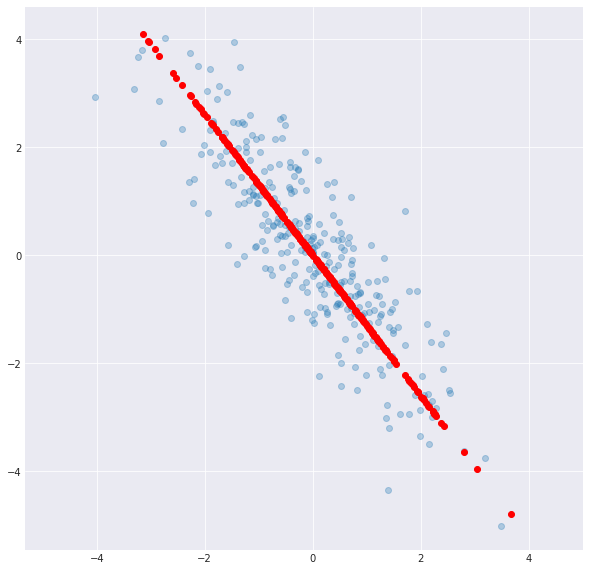

In [5]:
encoder_output = torch.mm(X_nn, W_encoder)
X_transformed_nn = torch.mm(encoder_output, W_decoder).data.numpy()

plt.figure(figsize=(10, 10))
plt.axis('equal')
plt.scatter(X[:, 0], X[:, 1], alpha=0.3);
plt.scatter(X_transformed_nn[:, 0], X_transformed_nn[:, 1], color='r');

На этом примере видно, что такой автоэнкодер делает то же самое, что и метод главных компонент. Однако вместо PCA его не используют. Автоэнкодерам есть применение получше.

Обучим автоэнкодер воспроизводить числа из датасета MNIST.  
Загрузим данные:

In [6]:
batch_size = 32
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

mnist_train = dset.MNIST("./data", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test  = dset.MNIST("./data", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True)

Создадим класс для модуля кодировщика. Он будет состоять из множества сверточных, пулинг слоев, а также слоев нормализации и активаций ReLU.

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(num_features=32),
                        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(num_features=64),
                        nn.MaxPool2d(kernel_size=2,stride=2)   # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(num_features=128),
                        nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(num_features=128),
                        nn.MaxPool2d(kernel_size=2,stride=2),
                        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

Точно так же для создадим класс для декодировщика. Он будет состоять из транспонированных сверточных слоев, активаций ReLU и слоев нормализации.

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=3,stride=2,padding=1,output_padding=1),
                        # stride=2, because this ConvTranspose is used to increase the spatial size, insted of MaxPool2d
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=3,stride=1,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=3,stride=1,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(in_channels=32,out_channels=1,kernel_size=3,stride=2,padding=1,output_padding=1),
                        # stride=2, because this ConvTranspose is used to increase the spatial size, insted of MaxPool2d
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

Создадим оптимизатор, зададим функцию ошибки, скажем сети, что мы собираемся обучать.

In [9]:
if use_cuda:
    encoder = Encoder().cuda()
    decoder = Decoder().cuda()
else:
    encoder = Encoder()
    decoder = Decoder()
learning_rate = 0.001

parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

Тренировка:

In [10]:
epochs = 1
for epoch in range(epochs):
    for image, label in tqdm_notebook(train_loader):
        image_var = Variable(image).type(dtype)
        optimizer.zero_grad()
        encoder_output = encoder(image_var)
        decoder_output = decoder(encoder_output)
        loss = loss_func(decoder_output, image_var)
        loss.backward()
        optimizer.step()
    torch.save([encoder,decoder],'./model/mnist_autoencoder.pkl')
    print("Epoch: %d, Loss: %.5f" % (epoch, loss.data.cpu().numpy()[0]))

A Jupyter Widget


Epoch: 0, Loss: 0.00078


Посмотрим, что получилось:

In [11]:
output_images = []
input_images = []
for image, label in train_loader:
    input_images.append(image.numpy().copy())
    image_var = Variable(image).type(dtype)
    encoder_output = encoder(image_var)
    out_image = decoder(encoder_output)
    
    output_images.append(out_image.data.cpu().numpy())
    break

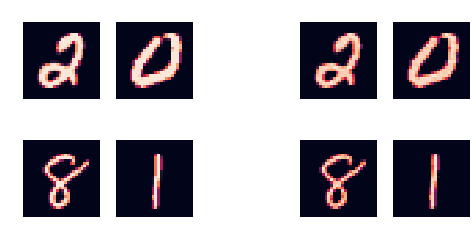

In [12]:
_, axes = plt.subplots(2, 5, figsize=(8, 4))
for ax in axes.reshape(-1):
    ax.axis('off')
axes[0,0].imshow(input_images[0][0].squeeze())
axes[0, 1].imshow(input_images[0][1].squeeze())
axes[1, 0].imshow(input_images[0][2].squeeze())
axes[1, 1].imshow(input_images[0][3].squeeze());

axes[0, 3].imshow(output_images[0][0].squeeze())
axes[0, 4].imshow(output_images[0][1].squeeze())
axes[1, 3].imshow(output_images[0][2].squeeze())
axes[1, 4].imshow(output_images[0][3].squeeze());

Ссылки:
1. [Код автокодировщика для MNIST отсюда](https://github.com/GunhoChoi/Kind-PyTorch-Tutorial/blob/master/07_Denoising_Autoencoder/Denoising_Autoencoder.ipynb)
2. [Бросание точек на плоскость, просто хороший материал про PCA](https://github.com/Yorko/mlcourse_open/blob/master/jupyter_russian/topic07_unsupervised/lesson7_part1_PCA.ipynb)
3. [Глава из Deep Learning Book](http://www.deeplearningbook.org/contents/autoencoders.html)